# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train_sam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 19            
model_seed = 9           

# --- Training configuration ---
epochs = 1500            

# --- Dataset configuration ---
base_data_size = 20      
dataset_type = "data"   
dataset_quantities = [0, 30, 80, 180, 380, 780]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the model module name
import swiss_model_data as model_module

test_dataset_size = 2000

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    base_data_size=base_data_size,
    dataset_quantities=dataset_quantities,
    test_dataset_size=test_dataset_size,
    noise=0.3, # default swiss params
    extra_pts=1000,
    dataset_type=dataset_type,
    seed=data_seed
)

# Swiss specific initialization parameters
input_dim = 2
output_dim = 1
hidden_dims = [32]*5

# Grab model
model_template = model_module.get_model(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim, device=device, seed=model_seed)

# Grab loss and metrics
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [4]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    torch.manual_seed(model_seed)
    model = copy.deepcopy(model_template)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    batch_size = len(x_train)

    # Train model
    train_loss, train_other_metrics, test_loss, test_other_metrics = train_sam(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=100,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_loss": train_loss,
        "test_loss": test_loss,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


[SAM] Epoch 1/1500: Train Loss 0.6931 | Test Loss 0.6973 | accs Train 0.4500 Test 0.3962


[SAM] Epoch 100/1500: Train Loss 0.1802 | Test Loss 1.7689 | accs Train 0.9500 Test 0.5180


[SAM] Epoch 200/1500: Train Loss 0.0415 | Test Loss 3.5201 | accs Train 1.0000 Test 0.5045


[SAM] Epoch 300/1500: Train Loss 0.0076 | Test Loss 4.5770 | accs Train 1.0000 Test 0.4955


[SAM] Epoch 400/1500: Train Loss 0.0020 | Test Loss 5.2651 | accs Train 1.0000 Test 0.4953


[SAM] Epoch 500/1500: Train Loss 0.0008 | Test Loss 5.7633 | accs Train 1.0000 Test 0.4948


[SAM] Epoch 600/1500: Train Loss 0.0005 | Test Loss 6.0842 | accs Train 1.0000 Test 0.4938


[SAM] Epoch 700/1500: Train Loss 0.0024 | Test Loss 6.6194 | accs Train 1.0000 Test 0.5000


[SAM] Epoch 800/1500: Train Loss 0.0004 | Test Loss 6.6295 | accs Train 1.0000 Test 0.4950


[SAM] Epoch 900/1500: Train Loss 0.0003 | Test Loss 6.7272 | accs Train 1.0000 Test 0.4920


[SAM] Epoch 1000/1500: Train Loss 0.0002 | Test Loss 6.8044 | accs Train 1.0000 Test 0.4925


[SAM] Epoch 1100/1500: Train Loss 0.0002 | Test Loss 6.8668 | accs Train 1.0000 Test 0.4925


[SAM] Epoch 1200/1500: Train Loss 0.0002 | Test Loss 6.9267 | accs Train 1.0000 Test 0.4928


[SAM] Epoch 1300/1500: Train Loss 0.0001 | Test Loss 6.9821 | accs Train 1.0000 Test 0.4920


[SAM] Epoch 1400/1500: Train Loss 0.0001 | Test Loss 7.0380 | accs Train 1.0000 Test 0.4915


[SAM] Epoch 1500/1500: Train Loss 0.0001 | Test Loss 7.0889 | accs Train 1.0000 Test 0.4910
Completed training with 0 additional samples of data
[SAM] Epoch 1/1500: Train Loss 0.6928 | Test Loss 0.6962 | accs Train 0.5200 Test 0.4920


[SAM] Epoch 100/1500: Train Loss 0.4456 | Test Loss 0.9533 | accs Train 0.7400 Test 0.5317


[SAM] Epoch 200/1500: Train Loss 0.1464 | Test Loss 1.1474 | accs Train 0.9600 Test 0.6610


[SAM] Epoch 300/1500: Train Loss 0.0308 | Test Loss 1.7052 | accs Train 1.0000 Test 0.6713


[SAM] Epoch 400/1500: Train Loss 0.0101 | Test Loss 2.1725 | accs Train 1.0000 Test 0.6663


[SAM] Epoch 500/1500: Train Loss 0.0052 | Test Loss 2.4160 | accs Train 1.0000 Test 0.6655


[SAM] Epoch 600/1500: Train Loss 0.0035 | Test Loss 2.5211 | accs Train 1.0000 Test 0.6647


[SAM] Epoch 700/1500: Train Loss 0.0017 | Test Loss 2.8279 | accs Train 1.0000 Test 0.6653


[SAM] Epoch 800/1500: Train Loss 0.0010 | Test Loss 3.0265 | accs Train 1.0000 Test 0.6660


[SAM] Epoch 900/1500: Train Loss 0.0008 | Test Loss 3.1540 | accs Train 1.0000 Test 0.6680


[SAM] Epoch 1000/1500: Train Loss 0.0005 | Test Loss 3.4342 | accs Train 1.0000 Test 0.6690


[SAM] Epoch 1100/1500: Train Loss 0.0004 | Test Loss 3.6387 | accs Train 1.0000 Test 0.6677


[SAM] Epoch 1200/1500: Train Loss 0.0003 | Test Loss 3.7904 | accs Train 1.0000 Test 0.6687


[SAM] Epoch 1300/1500: Train Loss 0.0003 | Test Loss 3.7951 | accs Train 1.0000 Test 0.6625


[SAM] Epoch 1400/1500: Train Loss 0.0002 | Test Loss 3.8467 | accs Train 1.0000 Test 0.6650


[SAM] Epoch 1500/1500: Train Loss 0.0002 | Test Loss 3.9081 | accs Train 1.0000 Test 0.6673
Completed training with 30 additional samples of data
[SAM] Epoch 1/1500: Train Loss 0.6953 | Test Loss 0.6958 | accs Train 0.4900 Test 0.4820


[SAM] Epoch 100/1500: Train Loss 0.4843 | Test Loss 0.5466 | accs Train 0.8300 Test 0.7565


[SAM] Epoch 200/1500: Train Loss 0.1185 | Test Loss 0.2084 | accs Train 0.9800 Test 0.9475


[SAM] Epoch 300/1500: Train Loss 0.0363 | Test Loss 0.1031 | accs Train 1.0000 Test 0.9842


[SAM] Epoch 400/1500: Train Loss 0.0176 | Test Loss 0.0848 | accs Train 1.0000 Test 0.9842


[SAM] Epoch 500/1500: Train Loss 0.0092 | Test Loss 0.0797 | accs Train 1.0000 Test 0.9840


[SAM] Epoch 600/1500: Train Loss 0.0056 | Test Loss 0.0764 | accs Train 1.0000 Test 0.9840


[SAM] Epoch 700/1500: Train Loss 0.0034 | Test Loss 0.0807 | accs Train 1.0000 Test 0.9838


[SAM] Epoch 800/1500: Train Loss 0.0021 | Test Loss 0.0761 | accs Train 1.0000 Test 0.9850


[SAM] Epoch 900/1500: Train Loss 0.0015 | Test Loss 0.0847 | accs Train 1.0000 Test 0.9838


[SAM] Epoch 1000/1500: Train Loss 0.0010 | Test Loss 0.0791 | accs Train 1.0000 Test 0.9855


[SAM] Epoch 1100/1500: Train Loss 0.0007 | Test Loss 0.0866 | accs Train 1.0000 Test 0.9845


[SAM] Epoch 1200/1500: Train Loss 0.0005 | Test Loss 0.0820 | accs Train 1.0000 Test 0.9858


[SAM] Epoch 1300/1500: Train Loss 0.0013 | Test Loss 0.1007 | accs Train 1.0000 Test 0.9825


[SAM] Epoch 1400/1500: Train Loss 0.0012 | Test Loss 0.0637 | accs Train 1.0000 Test 0.9860


[SAM] Epoch 1500/1500: Train Loss 0.0008 | Test Loss 0.0701 | accs Train 1.0000 Test 0.9858
Completed training with 80 additional samples of data
[SAM] Epoch 1/1500: Train Loss 0.6959 | Test Loss 0.6956 | accs Train 0.4900 Test 0.4990


[SAM] Epoch 100/1500: Train Loss 0.5077 | Test Loss 0.5403 | accs Train 0.7500 Test 0.7205


[SAM] Epoch 200/1500: Train Loss 0.1129 | Test Loss 0.1690 | accs Train 0.9950 Test 0.9845


[SAM] Epoch 300/1500: Train Loss 0.0164 | Test Loss 0.0585 | accs Train 1.0000 Test 0.9868


[SAM] Epoch 400/1500: Train Loss 0.0068 | Test Loss 0.0530 | accs Train 1.0000 Test 0.9870


[SAM] Epoch 500/1500: Train Loss 0.0025 | Test Loss 0.0524 | accs Train 1.0000 Test 0.9868


[SAM] Epoch 600/1500: Train Loss 0.0014 | Test Loss 0.0492 | accs Train 1.0000 Test 0.9868


[SAM] Epoch 700/1500: Train Loss 0.0080 | Test Loss 0.0343 | accs Train 1.0000 Test 0.9902


[SAM] Epoch 800/1500: Train Loss 0.0031 | Test Loss 0.0283 | accs Train 1.0000 Test 0.9905


[SAM] Epoch 900/1500: Train Loss 0.0019 | Test Loss 0.0285 | accs Train 1.0000 Test 0.9898


[SAM] Epoch 1000/1500: Train Loss 0.0013 | Test Loss 0.0297 | accs Train 1.0000 Test 0.9898


[SAM] Epoch 1100/1500: Train Loss 0.0010 | Test Loss 0.0301 | accs Train 1.0000 Test 0.9895


[SAM] Epoch 1200/1500: Train Loss 0.0007 | Test Loss 0.0308 | accs Train 1.0000 Test 0.9890


[SAM] Epoch 1300/1500: Train Loss 0.0005 | Test Loss 0.0314 | accs Train 1.0000 Test 0.9892


[SAM] Epoch 1400/1500: Train Loss 0.0004 | Test Loss 0.0319 | accs Train 1.0000 Test 0.9892


[SAM] Epoch 1500/1500: Train Loss 0.0003 | Test Loss 0.0323 | accs Train 1.0000 Test 0.9892
Completed training with 180 additional samples of data
[SAM] Epoch 1/1500: Train Loss 0.6964 | Test Loss 0.6952 | accs Train 0.4900 Test 0.5000


[SAM] Epoch 100/1500: Train Loss 0.5299 | Test Loss 0.5324 | accs Train 0.6825 Test 0.6910


[SAM] Epoch 200/1500: Train Loss 0.1607 | Test Loss 0.1856 | accs Train 0.9900 Test 0.9715


[SAM] Epoch 300/1500: Train Loss 0.0423 | Test Loss 0.0628 | accs Train 0.9975 Test 0.9888


[SAM] Epoch 400/1500: Train Loss 0.0163 | Test Loss 0.0341 | accs Train 1.0000 Test 0.9930


[SAM] Epoch 500/1500: Train Loss 0.0066 | Test Loss 0.0251 | accs Train 1.0000 Test 0.9925


[SAM] Epoch 600/1500: Train Loss 0.0032 | Test Loss 0.0243 | accs Train 1.0000 Test 0.9918


[SAM] Epoch 700/1500: Train Loss 0.0024 | Test Loss 0.0257 | accs Train 1.0000 Test 0.9925


[SAM] Epoch 800/1500: Train Loss 0.0036 | Test Loss 0.0288 | accs Train 1.0000 Test 0.9920


[SAM] Epoch 900/1500: Train Loss 0.0018 | Test Loss 0.0293 | accs Train 1.0000 Test 0.9920


[SAM] Epoch 1000/1500: Train Loss 0.0012 | Test Loss 0.0308 | accs Train 1.0000 Test 0.9918


[SAM] Epoch 1100/1500: Train Loss 0.0009 | Test Loss 0.0322 | accs Train 1.0000 Test 0.9918


[SAM] Epoch 1200/1500: Train Loss 0.0007 | Test Loss 0.0335 | accs Train 1.0000 Test 0.9918


[SAM] Epoch 1300/1500: Train Loss 0.0005 | Test Loss 0.0348 | accs Train 1.0000 Test 0.9915


[SAM] Epoch 1400/1500: Train Loss 0.0004 | Test Loss 0.0358 | accs Train 1.0000 Test 0.9915


[SAM] Epoch 1500/1500: Train Loss 0.0003 | Test Loss 0.0366 | accs Train 1.0000 Test 0.9915
Completed training with 380 additional samples of data
[SAM] Epoch 1/1500: Train Loss 0.6976 | Test Loss 0.6952 | accs Train 0.4700 Test 0.5000


[SAM] Epoch 100/1500: Train Loss 0.5826 | Test Loss 0.5704 | accs Train 0.6425 Test 0.6703


[SAM] Epoch 200/1500: Train Loss 0.1137 | Test Loss 0.1247 | accs Train 0.9875 Test 0.9818


[SAM] Epoch 300/1500: Train Loss 0.0186 | Test Loss 0.0313 | accs Train 1.0000 Test 0.9950


[SAM] Epoch 400/1500: Train Loss 0.0070 | Test Loss 0.0214 | accs Train 1.0000 Test 0.9952


[SAM] Epoch 500/1500: Train Loss 0.0023 | Test Loss 0.0184 | accs Train 1.0000 Test 0.9950


[SAM] Epoch 600/1500: Train Loss 0.0042 | Test Loss 0.0212 | accs Train 1.0000 Test 0.9948


[SAM] Epoch 700/1500: Train Loss 0.0020 | Test Loss 0.0213 | accs Train 1.0000 Test 0.9948


[SAM] Epoch 800/1500: Train Loss 0.0013 | Test Loss 0.0216 | accs Train 1.0000 Test 0.9948


[SAM] Epoch 900/1500: Train Loss 0.0009 | Test Loss 0.0221 | accs Train 1.0000 Test 0.9948


[SAM] Epoch 1000/1500: Train Loss 0.0007 | Test Loss 0.0227 | accs Train 1.0000 Test 0.9950


[SAM] Epoch 1100/1500: Train Loss 0.0005 | Test Loss 0.0237 | accs Train 1.0000 Test 0.9948


[SAM] Epoch 1200/1500: Train Loss 0.0004 | Test Loss 0.0245 | accs Train 1.0000 Test 0.9948


[SAM] Epoch 1300/1500: Train Loss 0.0004 | Test Loss 0.0252 | accs Train 1.0000 Test 0.9948


[SAM] Epoch 1400/1500: Train Loss 0.0003 | Test Loss 0.0257 | accs Train 1.0000 Test 0.9948


[SAM] Epoch 1500/1500: Train Loss 0.0003 | Test Loss 0.0264 | accs Train 1.0000 Test 0.9948
Completed training with 780 additional samples of data


## Training Summary

In [5]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 7.0889 | accs: 0.4910
  30 samples | Test Loss: 3.9081 | accs: 0.6673
  80 samples | Test Loss: 0.0701 | accs: 0.9858
 180 samples | Test Loss: 0.0323 | accs: 0.9892
 380 samples | Test Loss: 0.0366 | accs: 0.9915
 780 samples | Test Loss: 0.0264 | accs: 0.9948

=== Model Diagnostics by Training Data ===

Dataset type: data, additional samples: 0
 Model    0 | Train Loss: 0.0001 | accs: 1.0000
 Model   30 | Train Loss: 0.0003 | accs: 1.0000
 Model   80 | Train Loss: 0.0006 | accs: 1.0000
 Model  180 | Train Loss: 0.0003 | accs: 1.0000
 Model  380 | Train Loss: 0.0003 | accs: 1.0000
 Model  780 | Train Loss: 0.0002 | accs: 1.0000

Dataset type: data, additional samples: 30
 Model    0 | Train Loss: 2.2106 | accs: 0.7400
 Model   30 | Train Loss: 0.0002 | accs: 1.0000
 Model   80 | Train Loss: 0.0006 | accs: 1.0000
 Model  180 | Train Loss: 0.0004 | accs: 1.0000
 Model  380 | Train Loss: 0.0003 | accs: 1.0000
 Model  780 | Train Loss:

### Model + Data Specific Verification

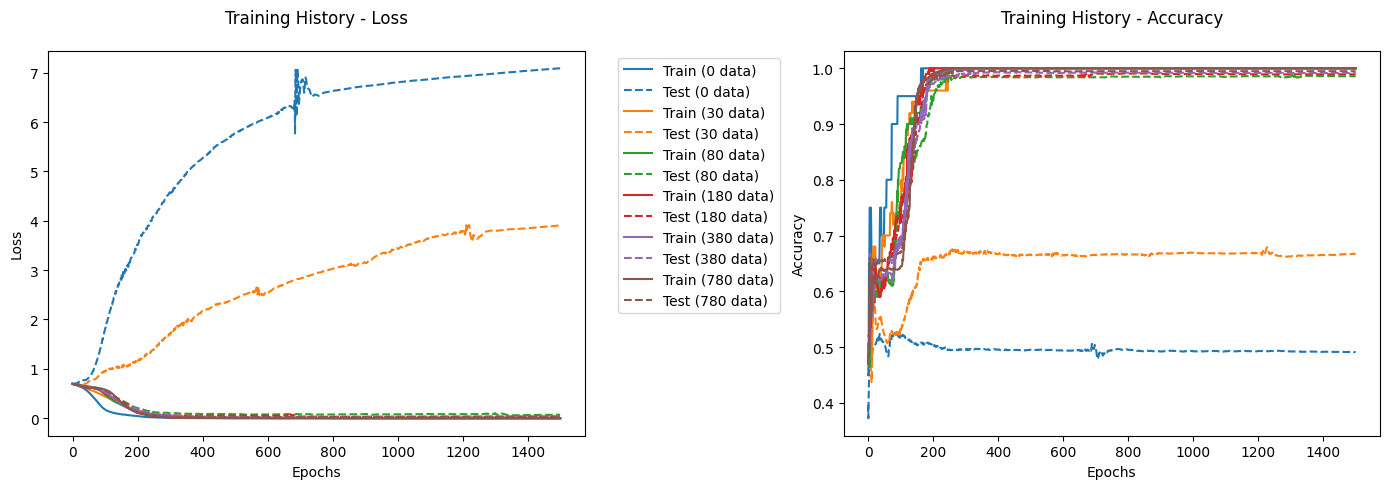

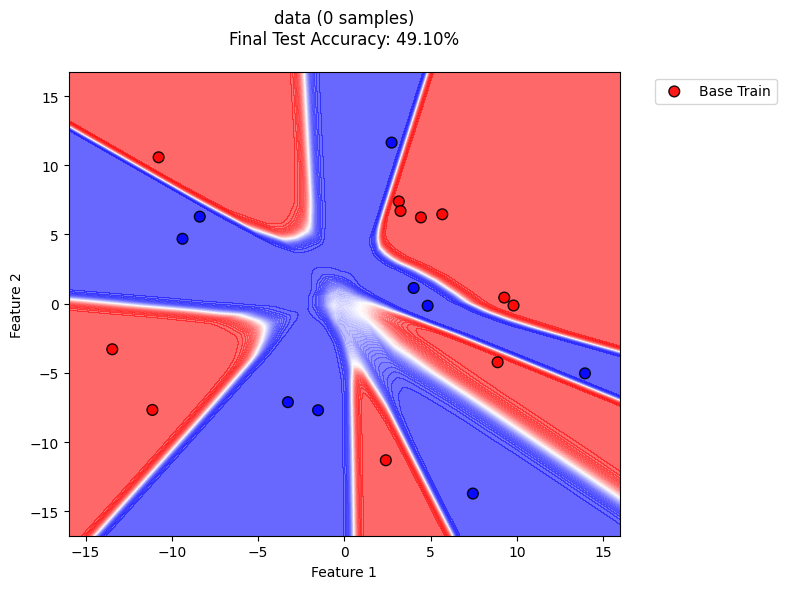

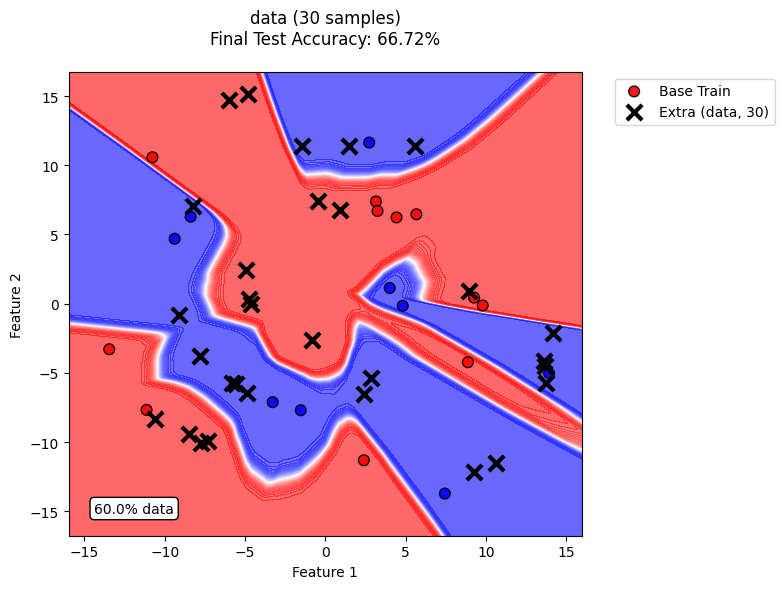

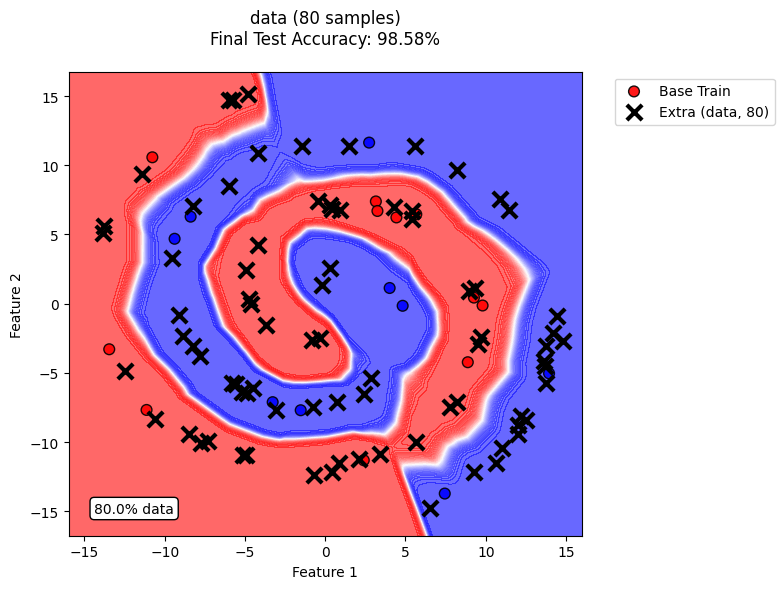

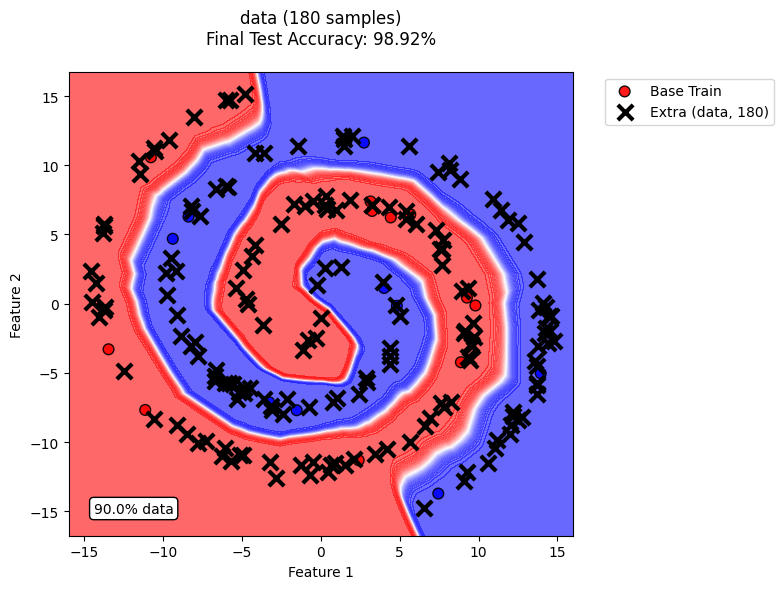

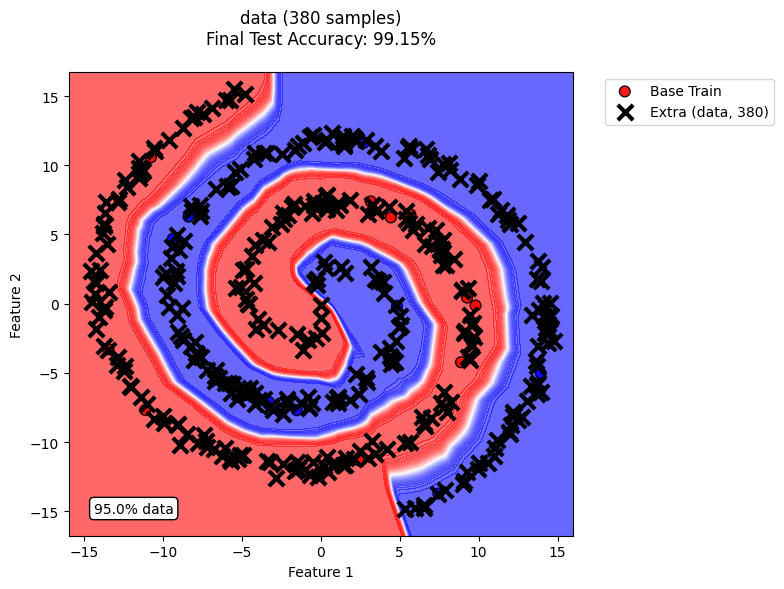

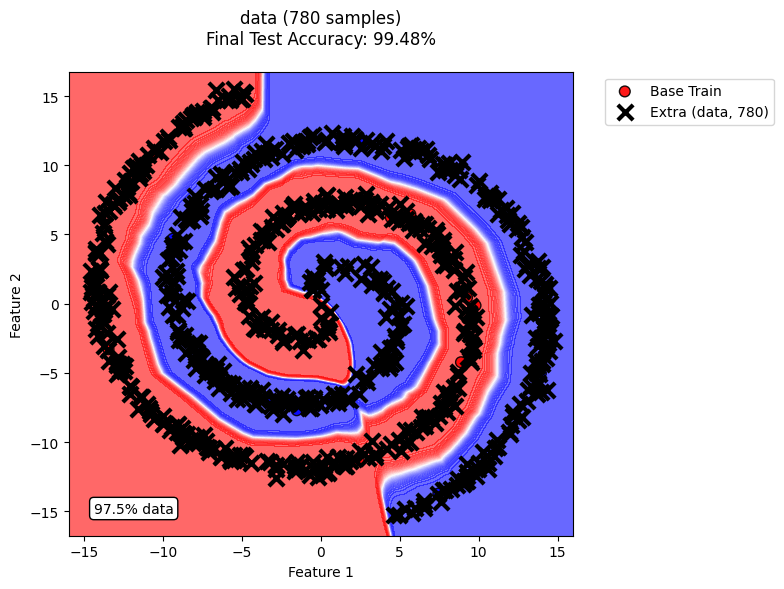

In [6]:
model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [7]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_loss=model_data["train_loss"],
            train_accs=model_data["train_accs"],
            test_loss=model_data["test_loss"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data\model_additional_30.pt
Saved model: models_and_data/model_additional_30.pt
✅ Model saved to models_and_data\model_additional_80.pt
Saved model: models_and_data/model_additional_80.pt
✅ Model saved to models_and_data\model_additional_180.pt
Saved model: models_and_data/model_additional_180.pt
✅ Model saved to models_and_data\model_additional_380.pt
Saved model: models_and_data/model_additional_380.pt
✅ Model saved to models_and_data\model_additional_780.pt
Saved model: models_and_data/model_additional_780.pt
